# # Plot bad actor with bias grid - helpfulness=True

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Load stylesheet to define fontsize, linewidth, etc.
plt.style.use("stylesheet.mplstyle")

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

## Definitions

In [2]:
result_dir = "bad_actor_with_bias_grid"
helpfulness = "helpfulness_True"

# import metrics, metric_names, and exp_to_y_axis_names from a global definition
metrics = json.load(open("definitions.json"))["metrics"]
metric_names = json.load(open("definitions.json"))["metric_names"]
exp_to_y_axis_names = json.load(open("definitions.json"))["exp_to_y_axis_names"]
ax_labels = json.load(open("definitions.json"))["ax_labels"]
conditions = json.load(open("definitions.json"))["conditions"]
condition_names = json.load(open("definitions.json"))["condition_names"]

## Read data

In [3]:
# Load data
df = pd.read_csv(f"{result_dir}/FP_count/{helpfulness}.csv")
# rescale st_prop to 0-100
df["st_prop"] = df["st_prop"] * 100

## Plot

In [4]:
## Helpers
def format_integer_ticks_from_labels(tick_map, val, pos=None, no_decimals=0):
    """
    Formatter that looks up the label from tick_map
    and formats it with custom rounding.
    tick_map: dict, mapping from tick index to label value
    """
    if val in tick_map:
        x = tick_map[val]
        if x % 1 == 0:
            return f"{int(round(x))}"
        return f"{x:.{no_decimals}f}"
    return ""  # hide ticks not in the mask

After conversion - NaN count: 0
After conversion - NaN count: 0
row: 0, col: 0, metric: p_h_U
row: 1, col: 0, metric: p_u_H
After conversion - NaN count: 0
After conversion - NaN count: 0
row: 0, col: 1, metric: p_h_U
row: 1, col: 1, metric: p_u_H


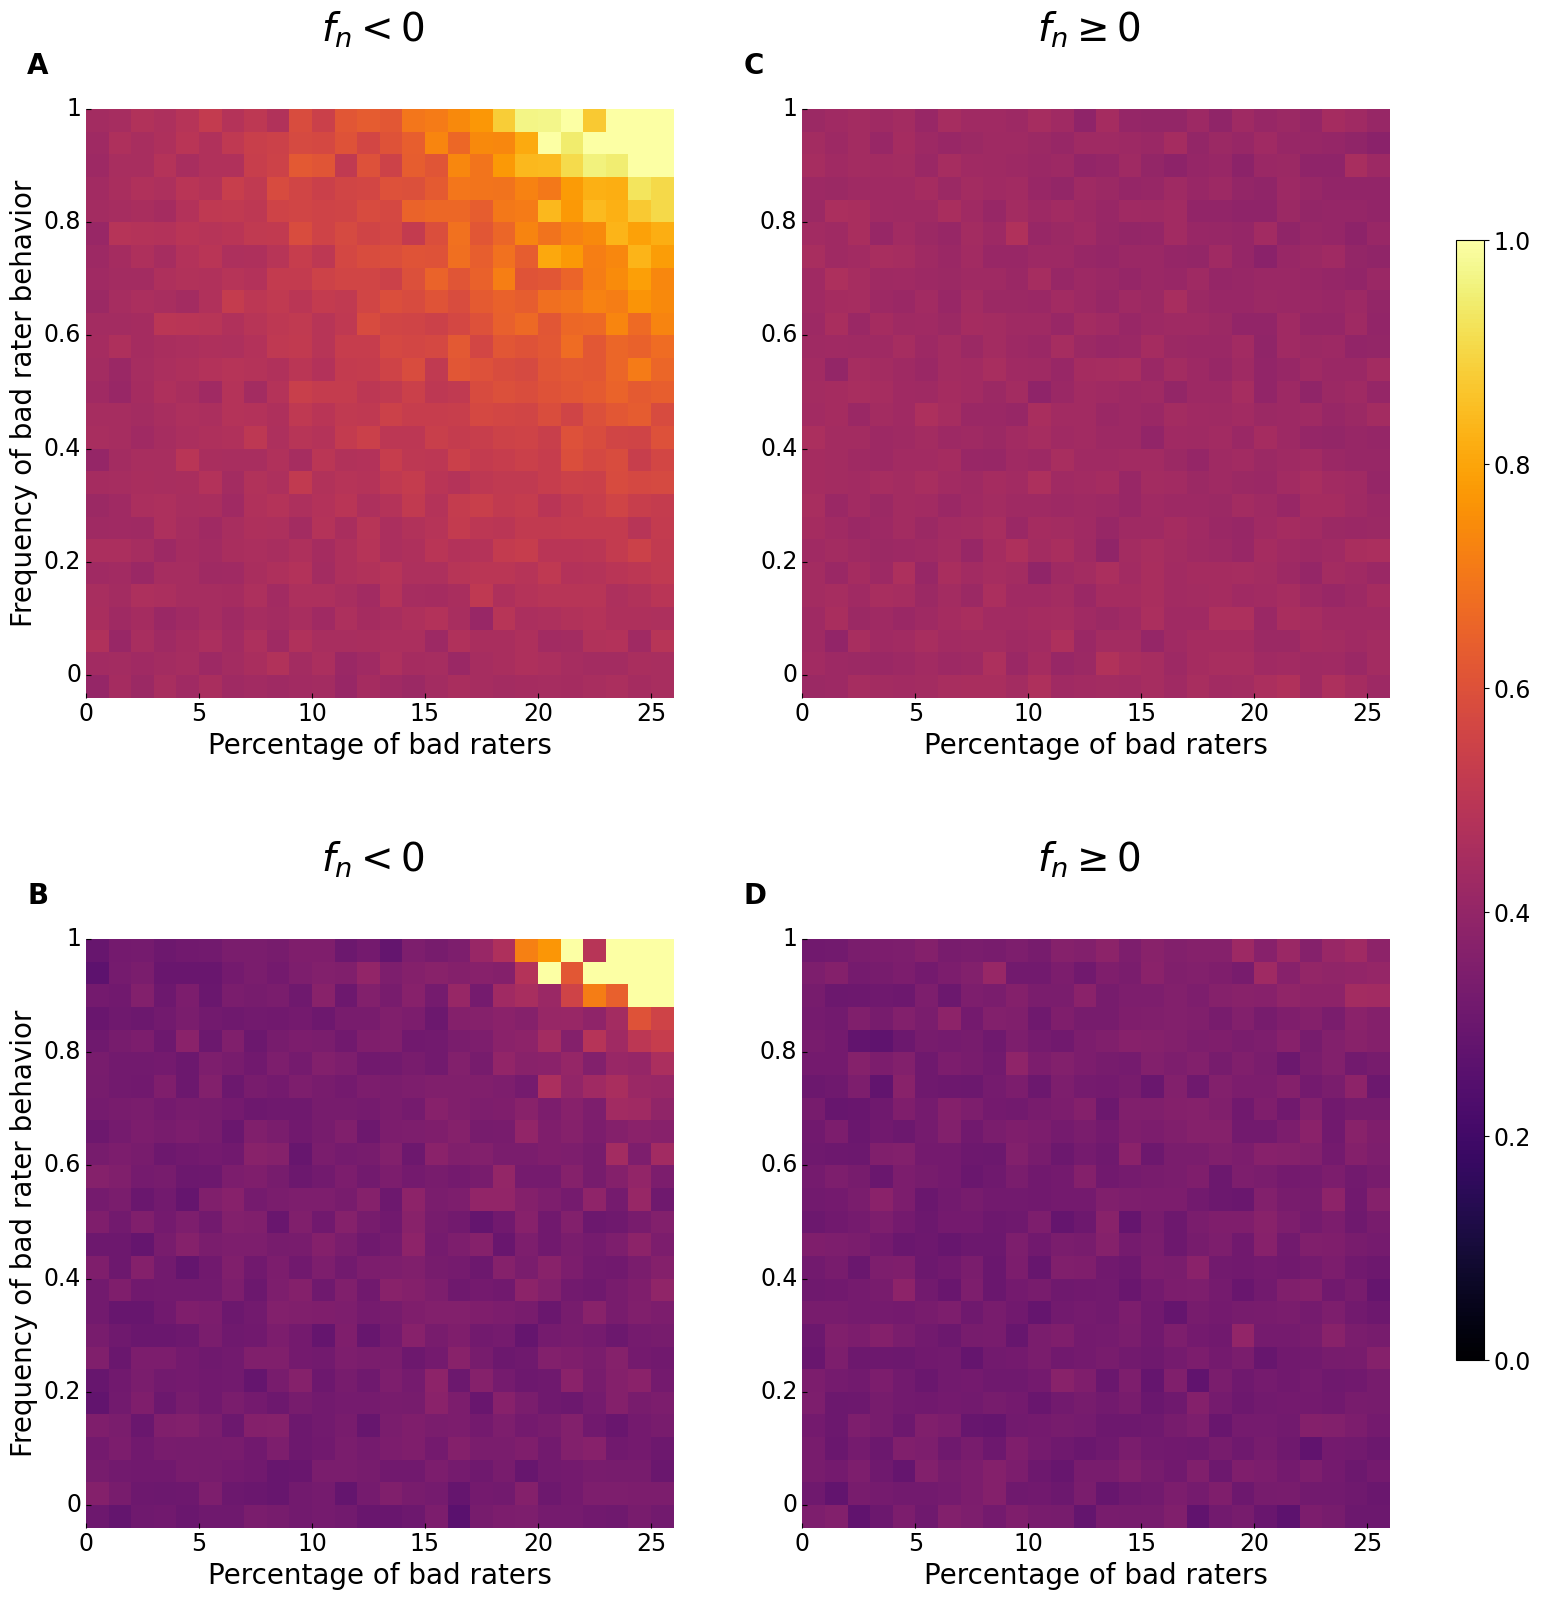

In [5]:
FIG_NAME = "Fig.3_biased_bad_"

fig_metrics = ["p_h_U", "p_u_H"]

# Set up subplot grid: 4 metrics × 2 conditions
n_rows = len(fig_metrics)
n_cols = len(conditions)
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(7 * n_cols, 8 * n_rows), layout="constrained"
)

# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,  # horizontal padding between subplots
    h_pad=0.1,  # vertical padding between subplots
    wspace=0.1,  # width space between subplots (similar to wspace in subplots_adjust)
    hspace=0.1,  # height space between subplots (similar to hspace in subplots_adjust)
)

# Fixed color scale across all heatmaps
vmin, vmax = 0.0, 1.0
cmap = "inferno"

mappable = None
j = 0
for col, condition in enumerate(conditions):
    # Filter for condition
    focal = df[df["condition"] == condition].copy()
    for metric in fig_metrics:
        # Convert to numeric and handle any conversion issues
        focal[metric] = pd.to_numeric(focal[metric], errors="coerce")
        print(f"After conversion - NaN count: {focal[metric].isna().sum()}")

    for row, metric in enumerate(fig_metrics):

        print(f"row: {row}, col: {col}, metric: {metric}")
        ax = axes[row, col]

        # Pivot table: rows = bhvr_rate, cols = st_prop
        hm = (
            focal.pivot_table(
                index="bhvr_rate", columns="st_prop", values=metric, aggfunc="mean"
            )
            .sort_index(ascending=False)  # y-axis sorted descending
            .reindex(
                sorted(focal["st_prop"].unique()), axis=1
            )  # x-axis sorted ascending
        )

        # Plot heatmap
        g = sns.heatmap(
            hm, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, fmt=".2f"
        )

        # Titles & labels
        if col == 0:
            ax.set_ylabel(ax_labels["bhvr_rate"])
        else:
            ax.set_ylabel("")
            ax.yaxis.set_label_position("right")  # no label, but keep ticks on right
            # ax.yaxis.tick_right()
        ax.set_title(
            f"{metric_names[metric]} ({condition_names[condition]})",
            color="white",
        )

        ax.set_xlabel(ax_labels["st_prop"])

        # ADD LABELS FOR LEFT- RIGHT-LEANING NOTES
        if row == 0 and col == 0:
            text_x_coord = 0.4
            text_y_coord = 1.1
        elif row == 0 and col == 1:
            text_x_coord = 0.4
            text_y_coord = 1.1
        ax.text(
            text_x_coord,
            text_y_coord,
            condition_names[condition],
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )

        # Add subplot labels (A, B, C, D) outside the subplot area
        subplot_labels = ["A", "B", "C", "D"]
        ax.text(
            -0.1,
            1.05,
            subplot_labels[j],
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0),
        )

        # Store first mappable for colorbar
        if mappable is None:
            mappable = g.collections[0]

        # Custom formatting
        import matplotlib.ticker as mticker

        ax.tick_params(direction="in")

        # Enable y-axis tick labels on the right
        plt.rcParams["ytick.right"] = True
        plt.rcParams["xtick.top"] = True

        # X axis ticks
        xvals = hm.columns.astype(float)  # numeric st_prop values
        xticks = np.arange(len(xvals))  # positions (0..N-1)
        # tick positions at step=0.1, plus max
        x_targets = np.arange(0, xvals.max() + 10, 5)
        x_targets = np.unique(np.append(x_targets, xvals.max()))
        xmask = np.isin(np.round(xvals, 3), np.round(x_targets, 3))
        # Build mapping from tick index (0..N-1) → your desired label value
        x_tick_map = dict(zip(xticks[xmask], xvals[xmask]))
        # Set ticks & Apply formatter
        ax.set_xticks(xticks[xmask])
        ax.set_xticklabels(xticks[xmask], rotation=0)
        # Y axis ticks
        yvals = hm.index.astype(float)  # numeric bhvr_rate values
        yticks = np.arange(0, len(yvals), 1)  # positions (0..M-1)
        ymask = np.isin(
            np.round(yvals, 2), np.round(np.arange(0, yvals.max() + 0.1, 0.1), 2)
        )
        y_tick_map = dict(zip(yticks[ymask], yvals[ymask]))
        # Set ticks & Apply formatter
        ax.set_yticks(yticks[ymask])
        # Apply formatter
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(
                lambda val, pos: format_integer_ticks_from_labels(
                    y_tick_map, val, pos, no_decimals=1
                )
            )
        )

        # Enforce horizontal tick labels
        ax.set_yticklabels(
            [
                format_integer_ticks_from_labels(y_tick_map, t, None, no_decimals=1)
                for t in yticks[ymask]
            ],
            rotation=0,
        )
        j += 1
# Add colorbar into a separate axis:
cax = fig.add_axes(
    [1.04, 0.15, 0.02, 0.7]
)  # [left, bottom, width, height] in figure coords
cb = fig.colorbar(mappable, cax=cax)

plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# Save outputs
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.pdf", dpi=300, bbox_inches="tight")

plt.show()

After conversion - NaN count: 0
After conversion - NaN count: 0
row: 0, col: 0, metric: p_H_u


row: 1, col: 0, metric: p_U_h
After conversion - NaN count: 0
After conversion - NaN count: 0
row: 0, col: 1, metric: p_H_u
row: 1, col: 1, metric: p_U_h


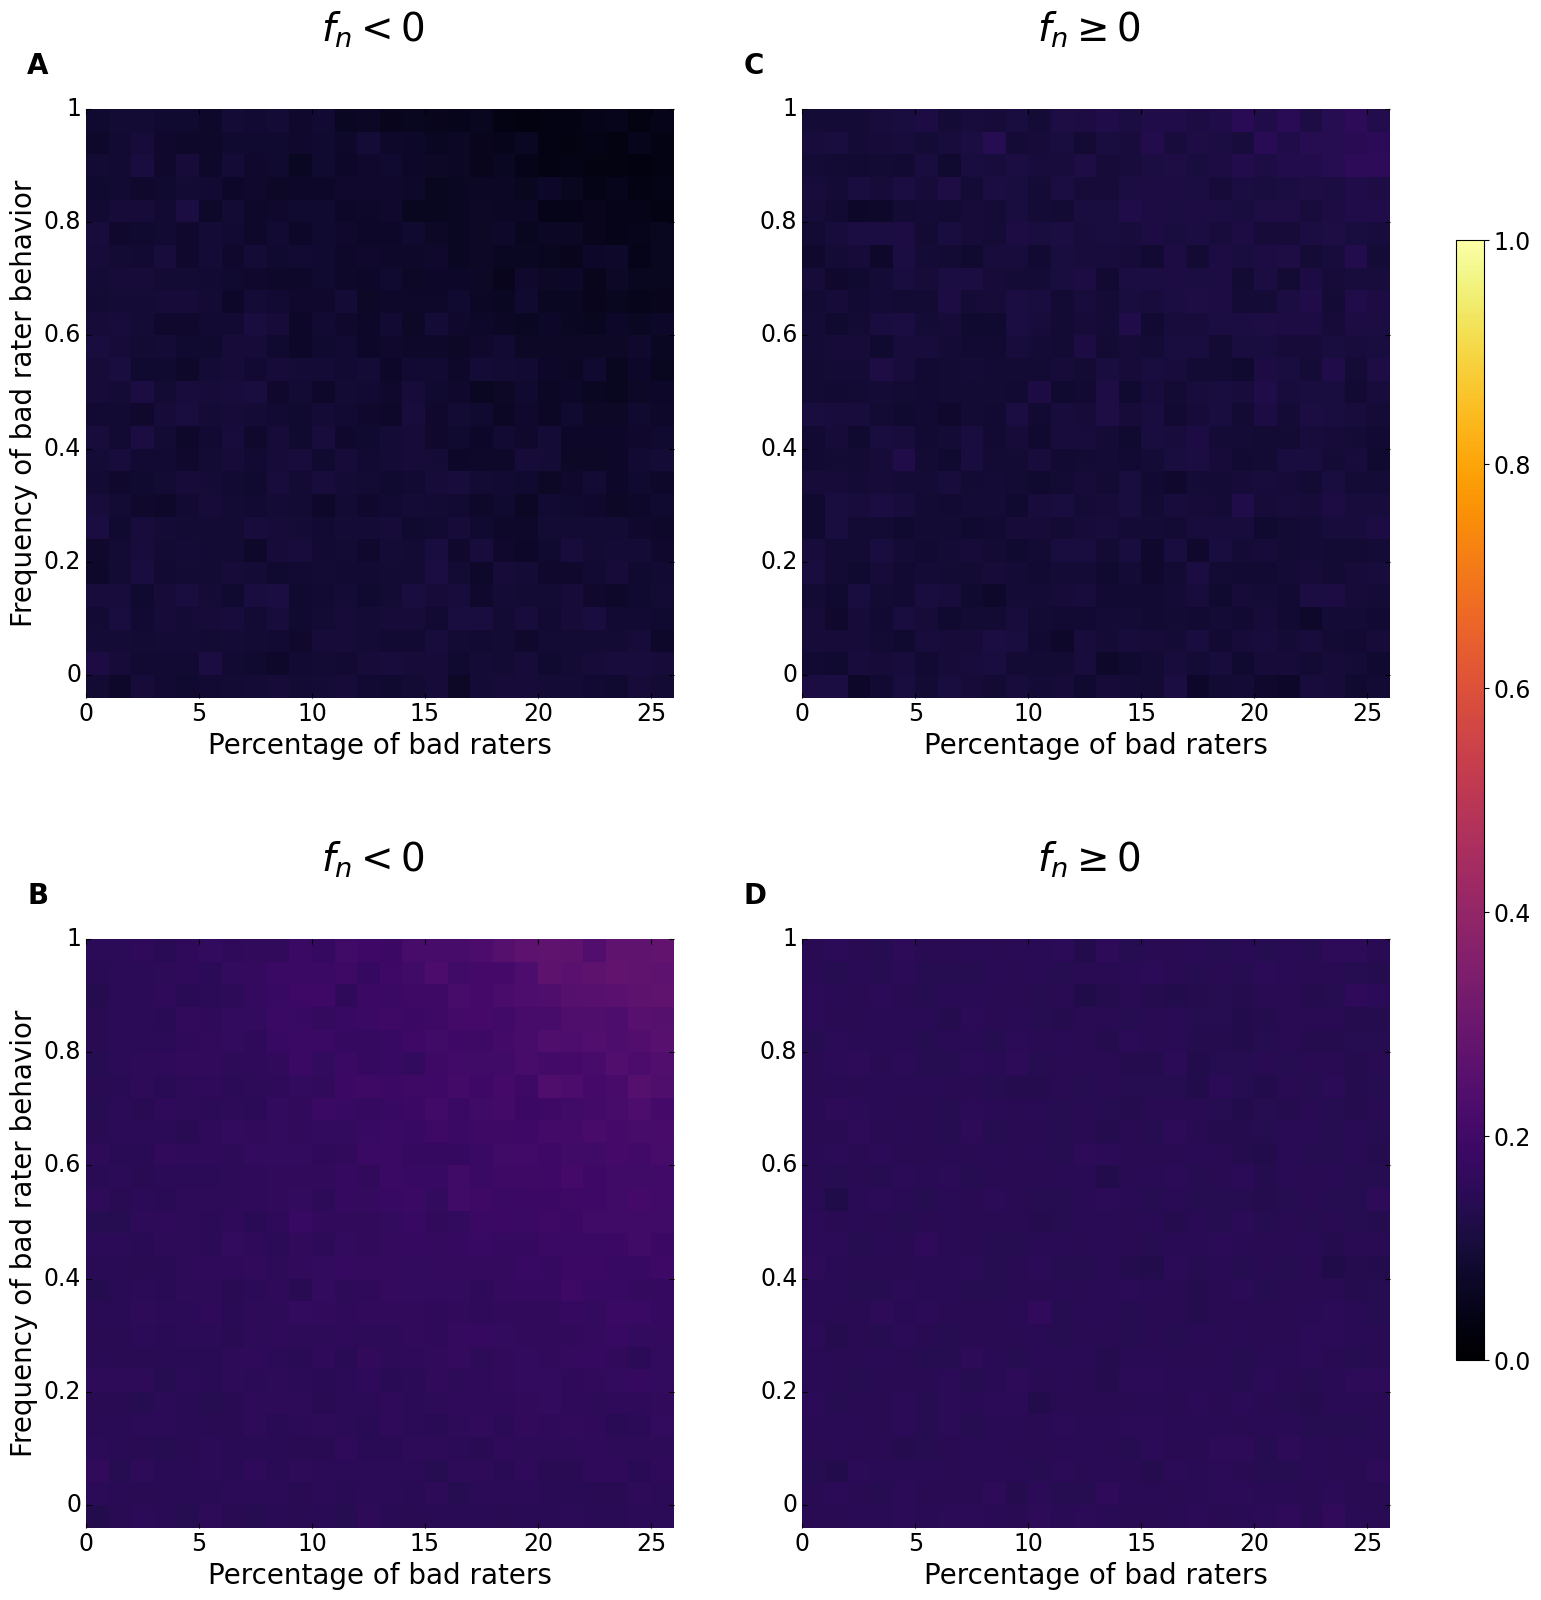

In [6]:
FIG_NAME = "supp_Fig.3_biased_bad_"

fig_metrics = ["p_H_u", "p_U_h"]

# Set up subplot grid: 4 metrics × 2 conditions
n_rows = len(fig_metrics)
n_cols = len(conditions)
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(7 * n_cols, 8 * n_rows), layout="constrained"
)

# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,  # horizontal padding between subplots
    h_pad=0.1,  # vertical padding between subplots
    wspace=0.1,  # width space between subplots (similar to wspace in subplots_adjust)
    hspace=0.1,  # height space between subplots (similar to hspace in subplots_adjust)
)

# Fixed color scale across all heatmaps
vmin, vmax = 0.0, 1.0
cmap = "inferno"

mappable = None
j = 0
for col, condition in enumerate(conditions):
    # Filter for condition
    focal = df[df["condition"] == condition].copy()
    for metric in fig_metrics:
        # Convert to numeric and handle any conversion issues
        focal[metric] = pd.to_numeric(focal[metric], errors="coerce")
        print(f"After conversion - NaN count: {focal[metric].isna().sum()}")

    for row, metric in enumerate(fig_metrics):

        print(f"row: {row}, col: {col}, metric: {metric}")
        ax = axes[row, col]

        # Pivot table: rows = bhvr_rate, cols = st_prop
        hm = (
            focal.pivot_table(
                index="bhvr_rate", columns="st_prop", values=metric, aggfunc="mean"
            )
            .sort_index(ascending=False)  # y-axis sorted descending
            .reindex(
                sorted(focal["st_prop"].unique()), axis=1
            )  # x-axis sorted ascending
        )

        # Plot heatmap
        g = sns.heatmap(
            hm, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, fmt=".2f"
        )

        # Titles & labels
        if col == 0:
            ax.set_ylabel(ax_labels["bhvr_rate"])
        else:
            ax.set_ylabel("")
            ax.yaxis.set_label_position("right")  # no label, but keep ticks on right
            # ax.yaxis.tick_right()
        ax.set_title(
            f"{metric_names[metric]} ({condition_names[condition]})", color="white"
        )

        ax.set_xlabel(ax_labels["st_prop"])

        # ADD LABELS FOR LEFT- RIGHT-LEANING NOTES
        if row == 0 and col == 0:
            text_x_coord = 0.4
            text_y_coord = 1.1
        elif row == 0 and col == 1:
            text_x_coord = 0.4
            text_y_coord = 1.1
        ax.text(
            text_x_coord,
            text_y_coord,
            condition_names[condition],
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )

        # Add subplot labels (A, B, C, D) outside the subplot area
        subplot_labels = ["A", "B", "C", "D"]
        ax.text(
            -0.1,
            1.05,
            subplot_labels[j],
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0),
        )

        # Store first mappable for colorbar
        if mappable is None:
            mappable = g.collections[0]

        # Custom formatting
        import matplotlib.ticker as mticker

        ax.tick_params(direction="in")

        # Enable y-axis tick labels on the right
        plt.rcParams["ytick.right"] = True
        plt.rcParams["xtick.top"] = True

        # X axis ticks
        xvals = hm.columns.astype(float)  # numeric st_prop values
        xticks = np.arange(len(xvals))  # positions (0..N-1)
        # tick positions at step=0.1, plus max
        x_targets = np.arange(0, xvals.max() + 10, 5)
        x_targets = np.unique(np.append(x_targets, xvals.max()))
        xmask = np.isin(np.round(xvals, 3), np.round(x_targets, 3))
        # Build mapping from tick index (0..N-1) → your desired label value
        x_tick_map = dict(zip(xticks[xmask], xvals[xmask]))
        # Set ticks & Apply formatter
        ax.set_xticks(xticks[xmask])
        ax.set_xticklabels(xticks[xmask], rotation=0)
        # Y axis ticks
        yvals = hm.index.astype(float)  # numeric bhvr_rate values
        yticks = np.arange(0, len(yvals), 1)  # positions (0..M-1)
        ymask = np.isin(
            np.round(yvals, 2), np.round(np.arange(0, yvals.max() + 0.1, 0.1), 2)
        )
        y_tick_map = dict(zip(yticks[ymask], yvals[ymask]))
        # Set ticks & Apply formatter
        ax.set_yticks(yticks[ymask])
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(
                lambda val, pos: format_integer_ticks_from_labels(
                    y_tick_map, val, pos, no_decimals=1
                )
            )
        )

        # Enforce horizontal tick labels
        ax.set_yticklabels(
            [
                format_integer_ticks_from_labels(y_tick_map, t, None, no_decimals=1)
                for t in yticks[ymask]
            ],
            rotation=0,
        )
        j += 1
# Add colorbar into a separate axis:
cax = fig.add_axes(
    [1.04, 0.15, 0.02, 0.7]
)  # [left, bottom, width, height] in figure coords
cb = fig.colorbar(mappable, cax=cax)

plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# Save outputs
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.pdf", dpi=300, bbox_inches="tight")

plt.show()